# Exercise 09 - Topology optimization for continua


## Task 1 - Book shelf

Let us consider a bookshelf that needs a support structure. The design domain is given by a unit square $x \in [0, 1]^2$ and a maximum thickness $d_{max}=0.1$. The left boundary of the domain $\partial \Omega_D$ is fixed to the wall and the top boundary $\partial \Omega_N$ is loaded with a uniform line load representing the weight of books.

<div>
    <center>
        <img src="../figures/domain.png" width="250"/>
    </center>
</div>


In [26]:
import torch
from simple_fem import FEM

torch.set_default_dtype(torch.double)

a) Modify the solution from last exercise and increase the number of elements per direction $N$ to 20.

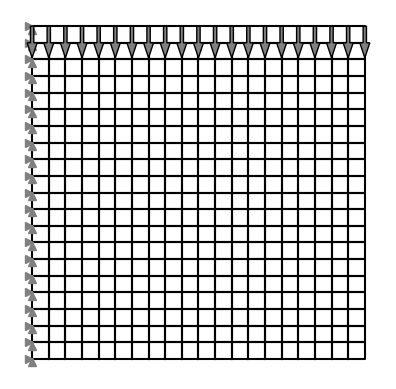

In [27]:
# Create nodes
N = 20
n1 = torch.linspace(0.0, 1.0, N + 1)
n2 = torch.linspace(0.0, 1.0, N + 1)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

# Create elements connecting nodes
elements = []
for j in range(N):
    for i in range(N):
        n0 = i + j * (N + 1)
        elements.append([n0, n0 + 1, n0 + N + 2, n0 + N + 1])

# Load at top
forces = torch.zeros_like(nodes)
forces[N * (N + 1) : (N + 1) * (N + 1), 1] = -1.0 / N

# Constrained displacement at left end
constraints = torch.zeros_like(nodes, dtype=bool)
for i in range(N + 1):
    constraints[i * (N + 1), :] = True

# Thickness
d = 0.1
thickness = d * torch.ones(len(elements))

# Material
E = 1000.0
nu = 0.25

# Create and plot the domain
square = FEM(nodes, elements, forces, constraints, thickness=thickness, E=E, nu=nu)
square.plot()

To save material, the bookshelf should use only 40% of the given design space, while being as stiff as possible to support many books. We want to achieve this by topology optimization of the component. You are provided with a function that performs root finding with the bisection method from a previous exercise. 

In [28]:
def bisection(f, a, b, max_iter=50, tol=1e-12):
    # Bisection method always finds a root, even with highly non-linear grad
    i = 0
    while (b - a) > tol:
        c = (a + b) / 2.0
        if i > max_iter:
            raise Exception(f"Bisection did not converge in {max_iter} iterations.")
        if f(a) * f(c) > 0:
            a = c
        else:
            b = c
        i += 1
    return c

b) Implement a topology optimization algorithm with *optimality conditions* in a function named `optimize(fem, rho_0, rho_min, rho_max, V_0, iter=100, xi=0.5, m=0.2, p=1.0, r=0.0)` that takes the FEM model `fem`, the initial density distribution `rho_0`, the minimum and maximum thickness distributions `rho_min, rho_max`, the volume constraint, the maximum iteration count `iter` with a default value of 100, a SIMP penality factor `p` with default 1, and a radius for sensitivity filtering `r` with a default 0.0.

In [29]:
def optimize(fem, rho_0, rho_min, rho_max, V_0, iter=100, xi=0.5, m=0.2, p=1.0, r=0.0):
    rho = [rho_0]
    vols = d * fem.areas()

    # Check if there is a feasible solution before starting iteration
    if torch.inner(rho_min, vols) > V_0:
        raise Exception("rho_min is not compatible with V_0.")

    # Precompute filter weights
    if r > 0.0:
        H = r - fem.dist
        H[fem.dist > r] = 0.0

    # Iterate solutions
    for k in range(iter):
        # Adjust thickness variables
        fem.thickness = d * rho[k] ** p

        # Compute solution
        u_k, f_k = fem.solve()

        # Compute sensitivities
        w_k = fem.element_strain_energies(u_k)
        sensitivity = -p * d * rho[k] ** (p - 1) * 2.0 * w_k

        # Filter sensitivities (if r provided)
        if r > 0.0:
            sensitivity = H @ (rho[k] * sensitivity) / H.sum(dim=0) / rho[k]

        # For a certain value of mu, apply the iteration scheme
        def make_step(mu):
            G_k = -sensitivity / (mu * vols)
            upper = torch.min(rho_max, (1 + m) * rho[k])
            lower = torch.max(rho_min, (1 - m) * rho[k])
            rho_trial = G_k**xi * rho[k]
            return torch.maximum(torch.minimum(rho_trial, upper), lower)

        # Constraint function
        def g(mu):
            rho_k = make_step(mu)
            return torch.dot(rho_k, vols) - V_0

        # Find the root of g(mu)
        mu = bisection(g, 1e-10, 100.0)

        # Evaluation
        compliance = torch.inner(f_k.ravel(), u_k.ravel())
        print(f"Iteration k={k} - Compliance: {compliance:.5f}")

        rho.append(make_step(mu))

    return rho

b) Set up the initial design variables $\rho_0=0.5, \rho_{min}=0.01, \rho_{max}=1.0$ and a volume constraint $V_0= 0.5 V_{max}$ with the maximum design volume $V_{max}$. 

In [30]:
# Initial thickness, minimum thickness, maximum thickness
rho_0 = 0.5 * torch.ones(len(square.elements))
rho_min = 0.01 * torch.ones_like(rho_0)
rho_max = 1.0 * torch.ones_like(rho_0)

# Initial volume (40% of maximum design volume)
vols = d * square.areas()
V0 = 0.4 * vols.sum()

c) Perform the optimization with 80 iterations and the following parameters: 
$$p=3$$
$$r=0$$ 

Iteration k=0 - Compliance: 0.16307
Iteration k=1 - Compliance: 0.30662
Iteration k=2 - Compliance: 0.23984
Iteration k=3 - Compliance: 0.20355
Iteration k=4 - Compliance: 0.17662
Iteration k=5 - Compliance: 0.15318
Iteration k=6 - Compliance: 0.13089
Iteration k=7 - Compliance: 0.11086
Iteration k=8 - Compliance: 0.09409
Iteration k=9 - Compliance: 0.08262
Iteration k=10 - Compliance: 0.07338
Iteration k=11 - Compliance: 0.06657
Iteration k=12 - Compliance: 0.06165
Iteration k=13 - Compliance: 0.05822
Iteration k=14 - Compliance: 0.05601
Iteration k=15 - Compliance: 0.05471
Iteration k=16 - Compliance: 0.05386
Iteration k=17 - Compliance: 0.05336
Iteration k=18 - Compliance: 0.05312
Iteration k=19 - Compliance: 0.05287
Iteration k=20 - Compliance: 0.05258
Iteration k=21 - Compliance: 0.05228
Iteration k=22 - Compliance: 0.05205
Iteration k=23 - Compliance: 0.05182
Iteration k=24 - Compliance: 0.05163
Iteration k=25 - Compliance: 0.05147
Iteration k=26 - Compliance: 0.05133
Iteration k

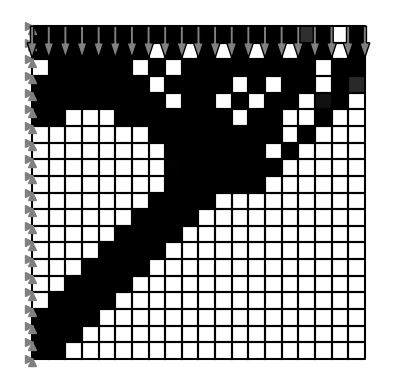

In [31]:
# Optimize and visualize results
d_opt = optimize(square, rho_0, rho_min, rho_max, V0, iter=50, p=3.0, r=0.0)
square.plot(element_property=d_opt[-1])

d) Plot the evolution of design variables vs. iterations. What does the graph tell you?

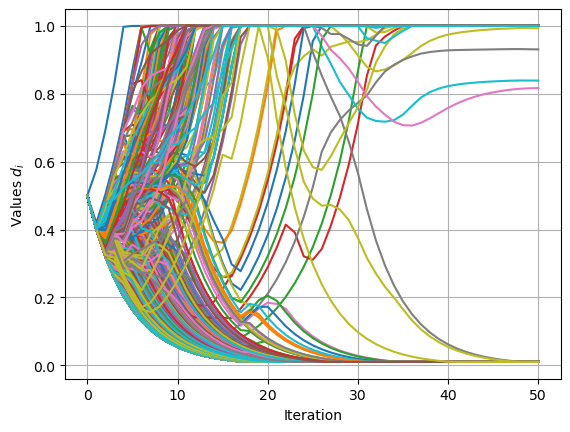

In [32]:
import matplotlib.pyplot as plt

plt.plot(torch.stack(d_opt).detach())
plt.xlabel("Iteration")
plt.ylabel("Values $d_i$")
plt.grid()

e) Perform the optimization with 250 iterations and the following parameters
$$p=3$$
$$r=0.06$$ 

Iteration k=0 - Compliance: 0.16307
Iteration k=1 - Compliance: 0.30875
Iteration k=2 - Compliance: 0.24092
Iteration k=3 - Compliance: 0.20459
Iteration k=4 - Compliance: 0.17807
Iteration k=5 - Compliance: 0.15473
Iteration k=6 - Compliance: 0.13313
Iteration k=7 - Compliance: 0.11353
Iteration k=8 - Compliance: 0.09666
Iteration k=9 - Compliance: 0.08487
Iteration k=10 - Compliance: 0.07618
Iteration k=11 - Compliance: 0.07013
Iteration k=12 - Compliance: 0.06587
Iteration k=13 - Compliance: 0.06312
Iteration k=14 - Compliance: 0.06117
Iteration k=15 - Compliance: 0.05975
Iteration k=16 - Compliance: 0.05880
Iteration k=17 - Compliance: 0.05811
Iteration k=18 - Compliance: 0.05761
Iteration k=19 - Compliance: 0.05724
Iteration k=20 - Compliance: 0.05692
Iteration k=21 - Compliance: 0.05660
Iteration k=22 - Compliance: 0.05628
Iteration k=23 - Compliance: 0.05598
Iteration k=24 - Compliance: 0.05574
Iteration k=25 - Compliance: 0.05552
Iteration k=26 - Compliance: 0.05536
Iteration k

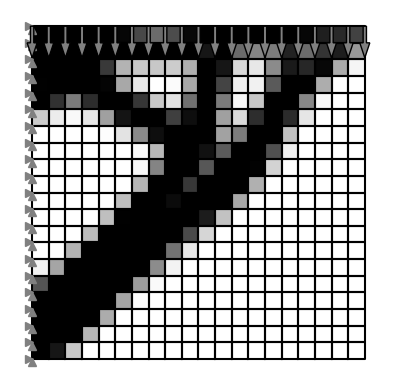

In [33]:
# Optimize and visualize results
d_opt = optimize(square, rho_0, rho_min, rho_max, V0, iter=250, p=3.0, r=0.06)
square.plot(element_property=d_opt[-1])

f) How do you interpret the design? Decide which manufacturing process you would like to use and use a CAD software to create a design based on your optimization.